In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


####Downloading the dataset

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.81MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.37MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Creating x_train and y_train with 1000 images from each class and binarizing the pixels

In [3]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

### Resizing the images from 28x28 to 14x14

In [4]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

### Binarizing 

In [5]:
# x_train = np.where(x_train > 128, 1, 0)
# x_val = np.where(x_val > 128, 1, 0)
# x_train = x_train.astype(np.float32)
# x_val = x_val.astype(np.float32)

### Scaling

In [6]:
x_train = (x_train/256).astype(np.float32)
x_val = (x_val/256).astype(np.float32)

### Creating dataloaders

In [7]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

###(ii)
### Variational Auto Encoder model

In [8]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
    def __init__(self, 
                 learned_covariance=False, 
                 gamma=0.1,
                 learned_noise=False,
                 sigma_dec=32):
        super(VAE, self).__init__()
        self.learned_covariance = learned_covariance
        self.gamma = 0.1
        self.learned_noise = learned_noise
        self.sigma_dec = sigma_dec

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma
        self.fccm = nn.Linear(128, 8*8) # Sigma covariance matrix

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        self.fc_sd = nn.Linear(128, 1) # Learned noising of decoder
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        if not self.learned_covariance:
            return self.fc21(h), self.fc22(h) # mu, std
        else:
            sigma = self.fccm(h).reshape(-1, 8,8)
            return self.fc21(h), sigma
    
    def sampling(self, mu, sigma): # Reparameterization trick
        if not self.learned_covariance:
            eps1 = torch.randn_like(sigma)
            eps2 = torch.randn_like(sigma)
            return 0.5*((eps1 * sigma + mu) + (eps2 * sigma + mu)) # Using two samples to compute expectation over z
        else:
            cov = sigma.transpose(1,2) @ sigma 
            cov += self.gamma * torch.eye(sigma.shape[-1]).to(sigma.device)
            mvn = torch.distributions.MultivariateNormal(mu, cov)
            eps = mvn.sample()
            return mu + eps

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        recon = torch.sigmoid(self.fc4(h))  # Reconstruction output

        if self.learned_noise:
            sigma_decoder = (1/2) * (self.sigma_dec * F.softplus(self.fc_sd(h)) + self.sigma_dec)  # Learned variance
        else:
            sigma_decoder = torch.full_like(recon, self.sigma_dec)  # Fixed variance

        return recon, sigma_decoder

    def forward(self, x):
        mu, sigma = self.encoder(x.view(-1, 196))  # Encode
        z = self.sampling(mu, sigma)  # Sample latent variable
        recon, sigma_decoder = self.decoder(z)  # Decode
        return recon, sigma_decoder, mu, sigma


    def quantize_gaussian_to_discrete(self, mu, sigma, num_bins=256):
        x = torch.linspace(0, num_bins - 1, num_bins).to(mu.device)
        mu_expanded = mu.unsqueeze(-1)  # Shape (B, H*W, 1)

        # Ensure sigma is correctly shaped
        if isinstance(sigma, torch.Tensor):
            sigma = sigma.unsqueeze(-1)  # Expand if needed
        else:
            sigma = torch.full_like(mu_expanded, sigma)  # Convert scalar to tensor


        norm = Normal(256 * mu_expanded, sigma)
        pdf = torch.exp(norm.log_prob(x))
        
        pdf_normalized = pdf / (pdf.sum(dim=-1, keepdim=True) + 1e-6)  # Prevent div-by-zero
        # pdf_normalized = pdf / (pdf.sum(dim=-1, keepdim=True))  # Prevent div-by-zero
        return torch.log(pdf_normalized + 1e-6)  # Avoid log(0)
        # return torch.log(pdf_normalized)  # Avoid log(0)

    def loss_function(self, recon, data, mu, std, sigma_decoder):
        log_pdfs = self.quantize_gaussian_to_discrete(recon, sigma_decoder)  # Use correct variance
        data = (256 * data).to(torch.int64).flatten(1,2).unsqueeze(-1)  # Convert to indices
        ERR = -torch.gather(log_pdfs, -1, data).squeeze(-1).sum()

        # Handle covariance matrix case
        if std.dim() == 3:  # Learned covariance matrix case
            B, D, _ = std.shape
            cov = std.transpose(1,2) @ std 
            cov += (self.gamma + 1e-6) * torch.eye(D, device=std.device)  # Stabilize
            log_det_cov = torch.logdet(cov + 1e-6 * torch.eye(D, device=std.device))  # Avoid log(0)
            trace_cov = torch.einsum('bii->b', cov)
            KLD = -0.5 * torch.sum(1 + log_det_cov - trace_cov - torch.sum(mu**2, dim=-1))
        else:  # Standard diagonal case
            KLD = -0.5 * torch.sum(1 + torch.log(std**2 + 1e-6) - mu**2 - std**2)

        return ERR + KLD, -ERR, -KLD, log_pdfs



### Defining loss, optimizer and LR scheduler

### Training and Validating

In [9]:
import torch
import torch.nn.functional as F

def train_model(model, 
                trainloader,
                testloader,
                optimizer, 
                scheduler, 
                num_epochs=20, 
                device="cuda"):
    """
    Train a given model using a variational autoencoder (VAE) training loop.
    
    Parameters:
    - model: The neural network model to train.
    - trainloader: DataLoader for training data.
    - testloader: DataLoader for test/validation data.
    - optimizer: Optimizer (e.g., Adam, SGD).
    - scheduler: Learning rate scheduler.
    - loss_function: Loss function for training (should handle both std as vector and matrix).
    - num_epochs: Number of training epochs.
    - device: "cuda" or "cpu".
    
    Returns:
    - err_l, kld_l, n_wu, testl, update: Lists tracking training progress.
    """
    model.to(device)
    err_l, kld_l, n_wu, testl, update = [], [], [], [], []
    count = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0

        for batch_idx, (data, _) in enumerate(trainloader):
            data = data.to(device)
            bsize = data.shape[0]

            # Forward pass
            recon_batch, sigma_decoder, mu, std = model(data)

            # Compute loss
            loss, err, kld, _ = model.loss_function(recon_batch, data, mu, std, sigma_decoder=sigma_decoder)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            train_loss += err.item() + kld.item()
            err_l.append(err.item() / bsize)
            kld_l.append(kld.item() / bsize)
            count += 1
            n_wu.append(count)

            # Validation every 100 updates
            if count % 100 == 0:
                model.eval()
                with torch.no_grad():
                    a, _ = next(iter(testloader))
                    a = a.to(device)
                    trecon, sigma_decoder, tmu, tstd = model(a)
                    tloss, terr, tkld, _ = model.loss_function(trecon, a, tmu, tstd, sigma_decoder=sigma_decoder)
                    testl.append(terr.item() / 100)
                    update.append(count)

        # Adjust learning rate
        scheduler.step(train_loss / len(trainloader.dataset))

        # Print training progress
        avg_train_loss = train_loss / len(trainloader.dataset)
        print(f"====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}")

        # Evaluate on the test set
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in testloader:
                data = data.to(device)
                recon, sigma_decoder, mu, std = model(data)
                loss, err, kld, log_pdfs = model.loss_function(recon, data, mu, std, sigma_decoder=sigma_decoder)
                # print("recon", recon[0][0])
                # print("sigma_decoder", sigma_decoder[0][0])
                # print("log_pdfs", log_pdfs[0][0])
                test_loss += err + kld
        
        test_loss /= len(testloader.dataset)
        print(f"====> Test set loss: {test_loss:.4f}")

    return err_l, kld_l, n_wu, testl, update


In [10]:
model = VAE()
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001)

vae_ret = train_model(
    model=model,
    trainloader=trainloader,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    device="cuda"
)

err_l, kld_l, n_wu, testl, update = vae_ret

====> Epoch: 1 Average loss: -1048.2265
====> Test set loss: -954.1616
====> Epoch: 2 Average loss: -933.2269
====> Test set loss: -915.0296
====> Epoch: 3 Average loss: -909.0389
====> Test set loss: -897.0767
====> Epoch: 4 Average loss: -897.5752
====> Test set loss: -893.4011
====> Epoch: 5 Average loss: -890.6822
====> Test set loss: -886.1340
====> Epoch: 6 Average loss: -884.1284
====> Test set loss: -881.2349
====> Epoch: 7 Average loss: -879.4291
====> Test set loss: -878.1609
====> Epoch: 8 Average loss: -876.1705
====> Test set loss: -874.4925
====> Epoch: 9 Average loss: -873.3552
====> Test set loss: -872.8867
====> Epoch: 10 Average loss: -870.5805
====> Test set loss: -870.4839
====> Epoch: 11 Average loss: -869.4224
====> Test set loss: -867.9273
====> Epoch: 12 Average loss: -866.7101
====> Test set loss: -866.5213
====> Epoch: 13 Average loss: -864.5028
====> Test set loss: -866.1958
====> Epoch: 14 Average loss: -864.3419
====> Test set loss: -864.9197
====> Epoch: 1

In [11]:
cv_model = VAE(learned_covariance=True, gamma=0.1)
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)
optimizer = torch.optim.Adam(cv_model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001)

cv_ret = train_model(
    model=cv_model,
    trainloader=trainloader,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    device="cuda"
)

err_l, kld_l, n_wu, testl, update = cv_ret

====> Epoch: 1 Average loss: -1040.9801
====> Test set loss: -959.4194
====> Epoch: 2 Average loss: -945.6659
====> Test set loss: -925.1722
====> Epoch: 3 Average loss: -921.4160
====> Test set loss: -912.4522
====> Epoch: 4 Average loss: -912.8595
====> Test set loss: -905.5899
====> Epoch: 5 Average loss: -905.7825
====> Test set loss: -901.4409
====> Epoch: 6 Average loss: -902.1876
====> Test set loss: -898.9995
====> Epoch: 7 Average loss: -899.1981
====> Test set loss: -895.6097
====> Epoch: 8 Average loss: -896.4594
====> Test set loss: -894.6047
====> Epoch: 9 Average loss: -894.6925
====> Test set loss: -892.8345
====> Epoch: 10 Average loss: -892.1257
====> Test set loss: -891.2218
====> Epoch: 11 Average loss: -890.5512
====> Test set loss: -888.2692
====> Epoch: 12 Average loss: -889.0530
====> Test set loss: -887.6162
====> Epoch: 13 Average loss: -887.8662
====> Test set loss: -886.4415
====> Epoch: 14 Average loss: -886.3429
====> Test set loss: -885.4753
====> Epoch: 1

In [12]:
noise_model = VAE(learned_noise=True)
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)
optimizer = torch.optim.Adam(noise_model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001)

noise_ret = train_model(
    model=noise_model,
    trainloader=trainloader,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    device="cuda"
)

err_l, kld_l, n_wu, testl, update = vae_ret

====> Epoch: 1 Average loss: -1011.6711
====> Test set loss: -949.3371
====> Epoch: 2 Average loss: -927.5706
====> Test set loss: -907.1244
====> Epoch: 3 Average loss: -899.2912
====> Test set loss: -884.7161
====> Epoch: 4 Average loss: -883.1836
====> Test set loss: -878.7724
====> Epoch: 5 Average loss: -876.4944
====> Test set loss: -869.8286
====> Epoch: 6 Average loss: -870.7107
====> Test set loss: -865.8774
====> Epoch: 7 Average loss: -866.2685
====> Test set loss: -862.2009
====> Epoch: 8 Average loss: -862.9752
====> Test set loss: -859.9146
====> Epoch: 9 Average loss: -860.5212
====> Test set loss: -859.8297
====> Epoch: 10 Average loss: -857.5708
====> Test set loss: -857.6559
====> Epoch: 11 Average loss: -854.7798
====> Test set loss: -856.0604
====> Epoch: 12 Average loss: -852.7550
====> Test set loss: -853.0410
====> Epoch: 13 Average loss: -850.5096
====> Test set loss: -852.5433
====> Epoch: 14 Average loss: -849.5009
====> Test set loss: -850.4224
====> Epoch: 1

In [13]:
noise_cv_model = VAE(learned_noise=True, learned_covariance=True, gamma=0.1)
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)
optimizer = torch.optim.Adam(noise_cv_model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001)

noise_cv_ret = train_model(
    model=noise_cv_model,
    trainloader=trainloader,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    device="cuda"
)

err_l, kld_l, n_wu, testl, update = vae_ret

====> Epoch: 1 Average loss: -1005.8805
====> Test set loss: -951.4495
====> Epoch: 2 Average loss: -937.9833
====> Test set loss: -915.9806
====> Epoch: 3 Average loss: -912.4161
====> Test set loss: -901.8026
====> Epoch: 4 Average loss: -902.0550
====> Test set loss: -893.6982
====> Epoch: 5 Average loss: -895.4693
====> Test set loss: -890.2973
====> Epoch: 6 Average loss: -891.5061
====> Test set loss: -887.6417
====> Epoch: 7 Average loss: -890.2519
====> Test set loss: -891.4861
====> Epoch: 8 Average loss: -886.9295
====> Test set loss: -883.8084
====> Epoch: 9 Average loss: -884.3140
====> Test set loss: -882.3218
====> Epoch: 10 Average loss: -884.2080
====> Test set loss: -879.8365
====> Epoch: 11 Average loss: -881.2645
====> Test set loss: -877.8089
====> Epoch: 12 Average loss: -879.7245
====> Test set loss: -876.6315
====> Epoch: 13 Average loss: -877.6046
====> Test set loss: -875.1526
====> Epoch: 14 Average loss: -876.8279
====> Test set loss: -874.1506
====> Epoch: 1

### (iii) Plotting the first and second term of ELBO as a function of weight updates

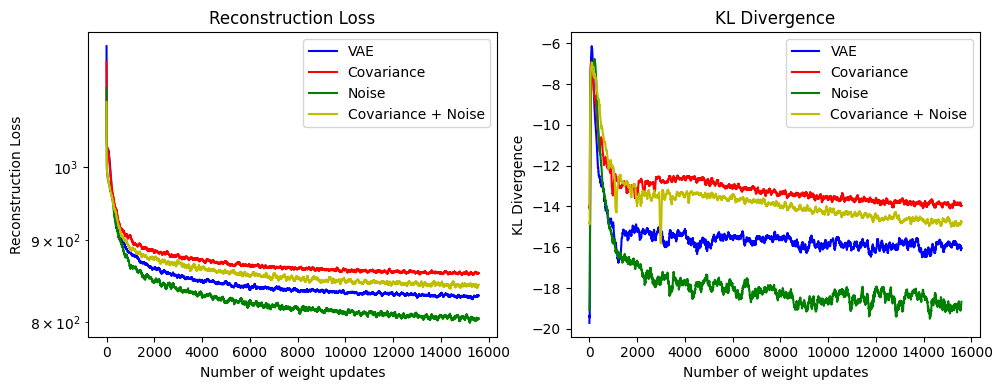

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_recon_and_kl_error(model_1_ret, model_2_ret, model_3_ret, model_4_ret, window_size=10):
    err_l_1, kld_l_1, n_wu_1, _, _ = model_1_ret
    err_l_2, kld_l_2, n_wu_2, _, _ = model_2_ret
    err_l_3, kld_l_3, n_wu_3, _, _ = model_3_ret
    err_l_4, kld_l_4, n_wu_4, _, _ = model_4_ret

    smoothed_err_l_1 = moving_average(abs(np.array(err_l_1)), window_size)
    smoothed_err_l_2 = moving_average(abs(np.array(err_l_2)), window_size)
    smoothed_err_l_3 = moving_average(abs(np.array(err_l_3)), window_size)
    smoothed_err_l_4 = moving_average(abs(np.array(err_l_4)), window_size)
    
    smoothed_kld_l_1 = moving_average(np.array(kld_l_1), window_size)
    smoothed_kld_l_2 = moving_average(np.array(kld_l_2), window_size)
    smoothed_kld_l_3 = moving_average(np.array(kld_l_3), window_size)
    smoothed_kld_l_4 = moving_average(np.array(kld_l_4), window_size)

    n_wu_1 = n_wu_1[:len(smoothed_err_l_1)]
    n_wu_2 = n_wu_2[:len(smoothed_err_l_2)]
    n_wu_3 = n_wu_3[:len(smoothed_err_l_3)]
    n_wu_4 = n_wu_4[:len(smoothed_err_l_4)]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
    
    axes[0].plot(n_wu_1, smoothed_err_l_1, 'b', label='VAE')
    axes[0].plot(n_wu_2, smoothed_err_l_2, 'r', label='Covariance')
    axes[0].plot(n_wu_3, smoothed_err_l_3, 'g', label='Noise')
    axes[0].plot(n_wu_4, smoothed_err_l_4, 'y', label='Covariance + Noise')
    axes[0].set_title('Reconstruction Loss')
    axes[0].set_xlabel('Number of weight updates')
    axes[0].set_ylabel('Reconstruction Loss')
    axes[0].set_yscale('log')
    axes[0].legend()
    
    axes[1].plot(n_wu_1, smoothed_kld_l_1, 'b', label='VAE')
    axes[1].plot(n_wu_2, smoothed_kld_l_2, 'r', label='Covariance')
    axes[1].plot(n_wu_3, smoothed_kld_l_3, 'g', label='Noise')
    axes[1].plot(n_wu_4, smoothed_kld_l_4, 'y', label='Covariance + Noise')
    axes[1].set_title('KL Divergence')
    axes[1].set_xlabel('Number of weight updates')
    axes[1].set_ylabel('KL Divergence')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_recon_and_kl_error(vae_ret, cv_ret, noise_ret, noise_cv_ret, window_size=70)


### (iv) 
### Visualizing input and output from the VAE from training set

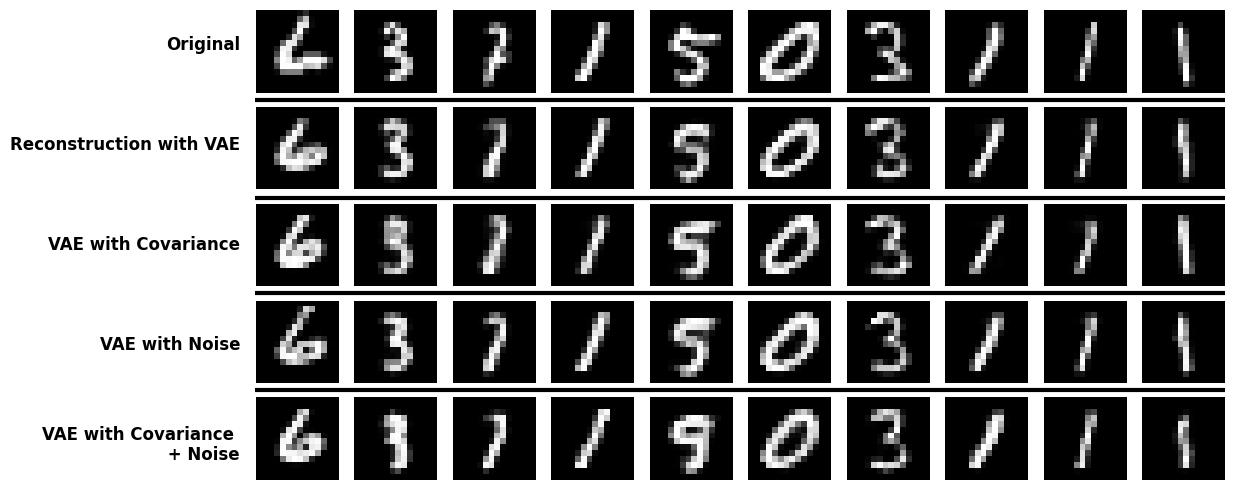

In [15]:
def compare_models(model1, model2, model3, model4, dataloader, device="cuda"):
    """
    Compares two models by reconstructing images and displaying results in an 8x12 grid.
    
    Parameters:
    - model1: First trained model.
    - model2: Second trained model.
    - dataloader: DataLoader for sampling images.
    - device: "cuda" or "cpu".
    
    Outputs:
    - Displays an 8x12 grid:
        - First 8x4: Original images
        - Second 8x4: Model 1 reconstructions (reshaped to 14x14)
        - Third 8x4: Model 2 reconstructions (reshaped to 14x14)
    """
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()

    fig, axes = plt.subplots(5, 10, figsize=(10, 5))  # 8 rows, 12 columns

    with torch.no_grad():
        for i in range(10):
            # Get a batch of images
            a, _ = next(iter(dataloader))
            a = a.to(device)

            for j in range(1):  # Get 4 images per row
                img = a[j]
                recon1, _, _, _ = model1(img.unsqueeze(0))  # Add batch dim
                recon2, _, _, _ = model2(img.unsqueeze(0))
                recon3, _, _, _ = model3(img.unsqueeze(0))  # Add batch dim
                recon4, _, _, _ = model4(img.unsqueeze(0))
                
                # Convert tensors to NumPy arrays for plotting
                original = img.detach().cpu().numpy().squeeze()
                recon1 = recon1[0].detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14
                recon2 = recon2[0].detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14
                recon3 = recon3[0].detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14
                recon4 = recon4[0].detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14

                # First section: Original images (8x4)
                axes[j, i].imshow(original, cmap="gray")
                
                # Second section: Model 1 reconstructions (8x4)
                axes[j+1, i].imshow(recon1, cmap="gray")

                # Third section: Model 2 reconstructions (8x4)
                axes[j+2, i].imshow(recon2, cmap="gray")
                axes[j+3, i].imshow(recon3, cmap="gray")
                axes[j+4, i].imshow(recon4, cmap="gray")

                # Remove axes for clean visualization
                for row in range(5):
                    axes[row, i].axis("off")

    fig.add_subplot(111, frameon=False)  # Invisible axis for lines
    plt.plot([0, 1], [0.21, 0.21], color='black', lw=3, transform=fig.transFigure)
    plt.plot([0, 1], [0.405, 0.405], color='black', lw=3, transform=fig.transFigure)
    plt.plot([0, 1], [0.595, 0.595], color='black', lw=3, transform=fig.transFigure)
    plt.plot([0, 1], [0.79, 0.79], color='black', lw=3, transform=fig.transFigure)

    plt.gca().set_xticks([])  # Remove x ticks
    plt.gca().set_yticks([])  # Remove y ticks

    # Add headers for each section
    fig.text(0.0, 0.9, 'Original', ha='right', va='center', fontsize=12, fontweight='bold')
    fig.text(0.0, 0.7, 'Reconstruction with VAE', ha='right', va='center', fontsize=12, fontweight='bold')
    fig.text(0.0, 0.5, 'VAE with Covariance', ha='right', va='center', fontsize=12, fontweight='bold')
    fig.text(0.0, 0.3, 'VAE with Noise', ha='right', va='center', fontsize=12, fontweight='bold')
    fig.text(0.0, 0.1, 'VAE with Covariance \n + Noise', ha='right', va='center', fontsize=12, fontweight='bold')


    plt.tight_layout()
    plt.show()

compare_models(model, cv_model, noise_model, noise_cv_model, trainloader, device="cuda")

### (v)
### Synthesizing MNIST images from a Standard Gaussian Distribution

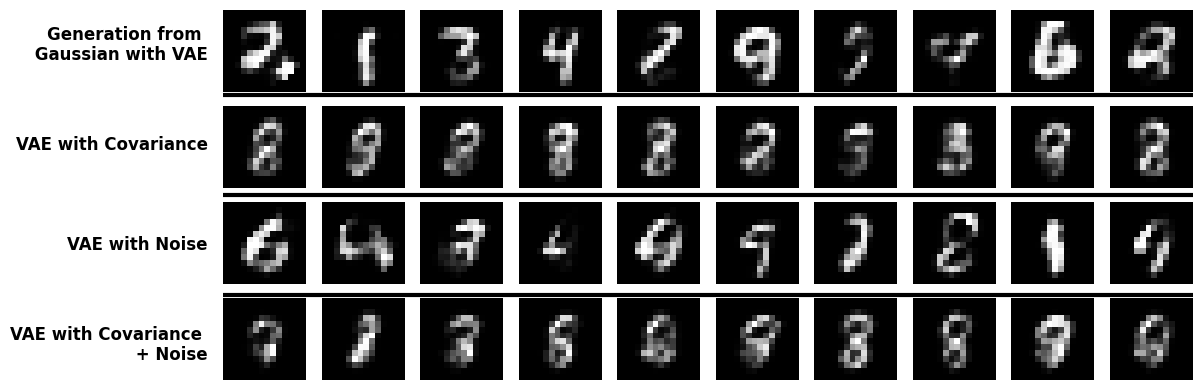

In [16]:
def generate_images(model1, model2, model3, model4, dataloader, device="cuda"):
    """
    Compares two models by reconstructing images and displaying results in an 8x12 grid.
    
    Parameters:
    - model1: First trained model.
    - model2: Second trained model.
    - dataloader: DataLoader for sampling images.
    - device: "cuda" or "cpu".
    
    Outputs:
    - Displays an 8x8 grid:
        - 1st 8x4: Model 1 reconstructions (reshaped to 14x14)
        - 2nd 8x4: Model 2 reconstructions (reshaped to 14x14)
    """
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()

    fig, axes = plt.subplots(4, 10, figsize=(10, 4))  # 8 rows, 12 columns

    with torch.no_grad():
        for i in range(10):
            for j in range(1):  # Get 4 images per row
                x = np.random.normal(0,1, 8)
                x= x.astype(np.float32)
                x=torch.from_numpy(x)
                x= x.cuda()
                recon1, _ = model1.decoder(x) # Add batch dim
                recon2, _ = model2.decoder(x)
                recon3, _ = model3.decoder(x)
                recon4, _ = model4.decoder(x)

                # Convert tensors to NumPy arrays for plotting
                recon1 = recon1.detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14
                recon2 = recon2.detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14
                recon3 = recon3.detach().cpu().numpy().reshape(14, 14)
                recon4 = recon4.detach().cpu().numpy().reshape(14, 14)
                
                # Second section: Model 1 reconstructions (8x4)
                axes[j, i].imshow(recon1, cmap="gray")

                # Third section: Model 2 reconstructions (8x4)
                axes[j+1, i].imshow(recon2, cmap="gray")
                axes[j+2, i].imshow(recon3, cmap="gray")
                axes[j+3, i].imshow(recon4, cmap="gray")

                # Remove axes for clean visualization
                for row in range(4):
                    axes[row, i].axis("off")

    fig.add_subplot(111, frameon=False)  # Invisible axis for lines
    plt.plot([0, 1], [0.25, 0.25], color='black', lw=3, transform=fig.transFigure)
    plt.plot([0, 1], [0.5, 0.5], color='black', lw=3, transform=fig.transFigure)
    plt.plot([0, 1], [0.75, 0.75], color='black', lw=3, transform=fig.transFigure)

    plt.gca().set_xticks([])  # Remove x ticks
    plt.gca().set_yticks([])  # Remove y ticks

    # Add headers for each section
    fig.text(0.0, 0.875, 'Generation from \n Gaussian with VAE', ha='right', va='center', fontsize=12, fontweight='bold')
    fig.text(0.0, 0.625, 'VAE with Covariance', ha='right', va='center', fontsize=12, fontweight='bold')
    fig.text(0.0, 0.375, 'VAE with Noise', ha='right', va='center', fontsize=12, fontweight='bold')
    fig.text(0.0, 0.125, 'VAE with Covariance \n + Noise', ha='right', va='center', fontsize=12, fontweight='bold')


    plt.tight_layout()
    plt.show()

generate_images(model, cv_model, noise_model, noise_cv_model, trainloader, device="cuda")